## Mapping acre trends and pheasant populations

In [1]:
import pandas as pd
import geopandas as gdp #reference for Geopandas https://geopandas.org/mapping.html 
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable # used to identify main plot axis
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # used to make a smaller axis for cax

**Load data sets**
1. FSA CRP acres expiring from 2020-2023
2. Shape file for US counties
2. Breeding Bird Survey.
    Mainpage https://www.usgs.gov/centers/pwrc/science/north-american-breeding-bird-survey?qt-science_center_objects=4#qt-science_center_objects </br>
    Trends and maps https://www.mbr-pwrc.usgs.gov/ </br>
    Data interface https://www.pwrc.usgs.gov/BBS/PublicDataInterface/index.cfm?fuseaction=PublicDataInterface.viewPublic 
    
**Data I used, species shape file** https://www.mbr-pwrc.usgs.gov/bbs/shape_ra15.shtml    
If this work is of value, should probably change to trend map of populations. https://www.mbr-pwrc.usgs.gov/bbs/tr2015/tr03091.htm </br>
Trend and populations maps can be found here https://www.mbr-pwrc.usgs.gov/bbs/geographic_information/GIS_shapefiles_2015.shtml 

In [2]:
# Data from NRCS Expiring acres
df= pd.read_csv('C:/code/CRP/Expiring_CRP_County_Gen_Con.csv',
                dtype={"FIPS": str}) #convert FIPs to string for mapping purposes. tutorial from herehttps://plotly.com/python/choropleth-maps/#base-map-configuration 

df.FIPS = df.FIPS.str.zfill(5) # added a zero as start to match the json "id"
df = df.rename(columns={'FIPS': 'CTFIPS'}) #change header name to map county shape file column name
df.head()
#df.info()

,STATE,COUNTY,CTFIPS,2020,2021,2022,2023,TOTAL
0,ALABAMA,AUTAUGA,01001,251.1,32.0,1004.9,445.2,1733.2
1,ALABAMA,BALDWIN,01003,378.6,630.0,1010.8,307.7,2327.1
2,ALABAMA,BARBOUR,01005,2091.2,1697.9,2919.8,2848.2,9557.1
3,ALABAMA,BIBB,01007,258.3,0.0,168.1,0.0,426.4
4,ALABAMA,BLOUNT,01009,112.8,185.2,120.1,56.5,474.6


In [59]:
# County shape file
fp= 'C:/code/us_county/US_County_Boundaries.shp'
#fp = 'C:/code/county_map/tl_2017_us_county.shp'
map_df = gdp.read_file(fp)

#map_df.head()
#map_df.info()
#map_df.plot()
df

,STATE,COUNTY,CTFIPS,2020,2021,2022,2023,TOTAL
0,ALABAMA,AUTAUGA,01001,251.1,32.0,1004.9,445.2,1733.2
1,ALABAMA,BALDWIN,01003,378.6,630.0,1010.8,307.7,2327.1
2,ALABAMA,BARBOUR,01005,2091.2,1697.9,2919.8,2848.2,9557.1
3,ALABAMA,BIBB,01007,258.3,0.0,168.1,0.0,426.4
4,ALABAMA,BLOUNT,01009,112.8,185.2,120.1,56.5,474.6
...,...,...,...,...,...,...,...,...
3112,WYOMING,UINTA,56041,0.0,0.0,0.0,0.0,0.0
3113,WYOMING,WASHAKIE,56043,140.6,0.0,32.6,80.1,253.3
3114,WYOMING,WESTON,56045,34.0,0.0,0.0,90.2,124.2
3115,PUERTO RICO,ALL,72999,0.0,0.0,0.0,60.0,60.0


**Merge the acres for CRP data and county data**

In [4]:
merged = pd.merge(left=map_df, right=df, on='CTFIPS')

In [50]:
# Drop luxury vacation spots out of jealousy and for display purposes
merged = merged.drop(merged[merged.STATE_x == 'Hawaii'].index)
merged['TOTAL']=merged['TOTAL']/1000

#merged.head()
#merged.info()

**Load pheasant file**
1. Common spatial location is the geometry column
2. Drop all data except for raster which is pixel density for orgin map weight of pheasant popoulations
3. Change projection to projection of US counties/acre map

In [58]:
#Pheasant population shapefile
birds= 'C:/code/pheasants/ra03091.shp'
#fp = 'C:/code/county_map/tl_2017_us_county.shp'
birds = gdp.read_file(birds)

#map_df.GEOID = map_df.STATEFP + map_df.COUNTYFP

#birds.head()
#map_df.info()
#map_df.plot()
birds

,AREA,PERIMETER,TMPCOV_,TMPCOV_ID,GRID_CODE,RASTAT,geometry
0,463155900.0,86181.89,2,7379,16992.0,0.089528,"POLYGON ((-1139129.625 3531775.500, -1138836.8..."
1,463161400.0,86181.81,3,7383,16993.0,0.069096,"POLYGON ((-1116742.875 3531207.750, -1116477.1..."
2,463131700.0,86174.22,4,7602,17184.0,0.062817,"POLYGON ((-1161192.000 3511616.500, -1160896.2..."
3,463136700.0,86174.14,5,7611,17185.0,0.055656,"POLYGON ((-1138836.875 3511064.500, -1138567.3..."
4,463142700.0,86174.12,6,7615,17186.0,0.084748,"POLYGON ((-1116477.125 3510501.500, -1116234.2..."
...,...,...,...,...,...,...,...
9571,460968400.0,85884.59,9573,30365,38194.0,0.084729,"POLYGON ((-341843.188 1148693.000, -342753.375..."
9572,460948700.0,85882.75,9574,30479,38332.0,0.974114,"POLYGON ((-491500.969 1133196.375, -492421.906..."
9573,460949700.0,85882.82,9575,30484,38333.0,1.086553,"POLYGON ((-470249.781 1132336.875, -471169.125..."
9574,460950300.0,85882.84,9576,30499,38336.0,0.188799,"POLYGON ((-406499.688 1129717.500, -407414.313..."


In [7]:
#Reference documentation https://automating-gis-processes.github.io/CSC/notebooks/L4/spatial-join.html 

birds_geo = birds.loc[0: , ['RASTAT','geometry']] # drop all columns except those needed for mapping
birds_geo=birds_geo.to_crs(merged.crs) # change the projection of bird_geo to merged with acres 

In [8]:
# confirm data sets are on same projection
birds_geo.crs == merged.crs 

True

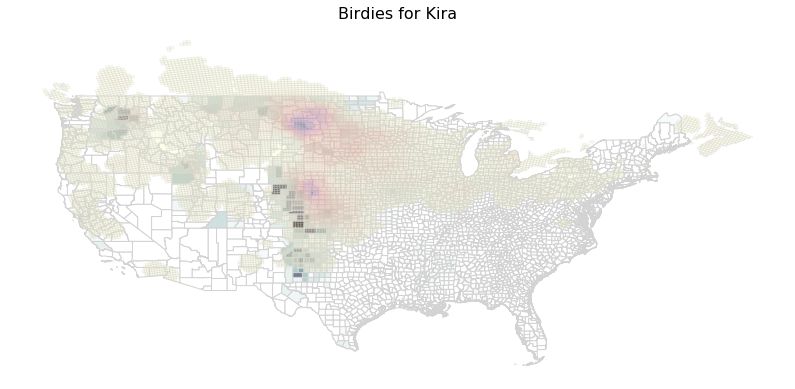

In [61]:
fig, ax = plt.subplots(figsize=(14, 20))
ax.set_aspect('equal')

merged.plot(column=merged.TOTAL, ax=ax, cmap="bone_r", edgecolor='lightgray')
birds_geo.plot(column=birds_geo.RASTAT, ax=ax, cmap="magma_r", edgecolor='lightgray', alpha=0.3) #alpha is a transparency attribute
#birds_geo.scatter(column=birds_geo.RASTAT)

ax.set_title('Birdies for Kira', size = 16, loc='center')

ax.set_axis_off()
plt.show();